In [30]:
!pip install pandas
!pip install spacy
!python -m spacy download en_core_web_sm
!pip install vaderSentiment
!pip install matplotlib

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
     |████████████████████████████████| 12.4 MB 11.7 MB/s eta 0:00:01


     |████████████████████████████████| 88 kB 4.0 MB/s  eta 0:00:01
     |████████████████████████████████| 67 kB 4.3 MB/s  eta 0:00:01


# Listings

In [2]:
import pandas as pd

df_2020_03 = pd.read_csv('http://data.insideairbnb.com/united-states/ma/boston/2020-03-16/data/listings.csv.gz', compression='gzip')
df_2019_18 = pd.read_csv('http://data.insideairbnb.com/united-states/ma/boston/2019-10-18/data/listings.csv.gz', compression='gzip')
df_2018_10 = pd.read_csv('http://data.insideairbnb.com/united-states/ma/boston/2018-10-11/data/listings.csv.gz', compression='gzip')
df_2017_10 = pd.read_csv('http://data.insideairbnb.com/united-states/ma/boston/2017-10-06/data/listings.csv.gz', compression='gzip')
df_2016_09 = pd.read_csv('http://data.insideairbnb.com/united-states/ma/boston/2016-09-07/data/listings.csv.gz', compression='gzip')
df_2015_10 = pd.read_csv('http://data.insideairbnb.com/united-states/ma/boston/2015-10-03/data/listings.csv.gz', compression='gzip')

df_original_listings = pd.concat([df_2020_03, df_2019_18, df_2018_10, df_2017_10, df_2016_09, df_2015_10]).drop_duplicates('id')
# df_original_listings = pd.concat([df_2020_03, df_2019_18, df_2018_10, df_2017_10, df_2016_09]).drop_duplicates('id')
# df_original_listings = pd.concat([df_2020_03, df_2019_18]).drop_duplicates('id')
print('Len total =', len(df_original_listings))

df_listings = df_original_listings.copy()
df_listings = df_listings.replace('nan', '', regex=True)
df_listings['summary'] = df_listings['summary'].astype(str)
df_listings['space'] = df_listings['space'].astype(str)
df_listings['description'] = df_listings['description'].astype(str)
df_listings['neighborhood_overview'] = df_listings['neighborhood_overview'].astype(str)
df_listings['host_neighbourhood'] = df_listings['host_neighbourhood'].astype(str)
df_listings['neighbourhood_cleansed'] = df_listings['neighbourhood_cleansed'].astype(str)
df_listings['notes'] = df_listings['notes'].astype(str)
df_listings['review_scores_rating'] = df_listings['review_scores_rating'].astype(float)
df_listings = df_listings[df_listings['review_scores_rating'].notna()]
print(len(df_listings))
df_listings['review_scores_rating']

Len total = 12480
9684


0        99.0
1        95.0
2        96.0
3        93.0
4        95.0
        ...  
2552     96.0
2554     99.0
2555     99.0
2556    100.0
2557     87.0
Name: review_scores_rating, Length: 9684, dtype: float64

In [19]:
from collections import Counter
from itertools import chain
import itertools
import string
import re
import spacy

# Download the natural language dataset for english, if this is the first run
# !python -m spacy download en_core_web_sm

# Load spacy
import en_core_web_sm
nlp = en_core_web_sm.load()

# Add in common words that occurr in all listings, that really don't mean anything useful here
nlp.Defaults.stop_words |= {'many', 'great', 'nearby', 'short', 'major', 'north', 'south', 'east', 'west', 'easy', 'true', 'local', 'public', 'mi', 'several', 'such', 'main', 'other'}

# Creates a Counter of adjectives used in the "neighborhood overview" field of all listings
# within the neighborhood name provided. 
def get_neighborhood_adjectives(name):
  
  # List of the "neighborhood_overview" field for all listings for this neighborhood
  overviews = df_listings.loc[df_listings['neighbourhood_cleansed'] == name]['neighborhood_overview']
  
  list_overviews = '  '.join([overview for overview in overviews])
    
  # Combine all overviews into one, and load it into spacy
  text = nlp(list_overviews)
  
  # Get the adjectives
  adjectives = [token.lemma_ for token in text if token.pos_ == "ADJ" and not token.is_stop]
  
  # Count the adjectives
  counter = Counter(adjectives)
  
  # Remove pronoun forms
  counter.pop('-PRON-', None)
  
  return (len(overviews), counter)

  
north_end = get_neighborhood_adjectives('North End')
print('Listings in north end:', north_end[0])
print('North end is:', north_end[1])

Listings in north end: 347
North end is: Counter({'italian': 182, 'historic': 121, 'good': 88, 'old': 75, 'entire': 45, 'narrow': 34, 'fine': 31, 'famous': 29, 'amazing': 27, 'residential': 26, 'american': 26, 'close': 25, 'european': 19, 'rich': 16, 'fresh': 16, 'accessible': 16, 'authentic': 15, 'beautiful': 15, 'safe': 14, 'colonial': 14, 'yummy': 14, 'friendly': 13, 'perfect': 13, 'favorite': 13, 'notable': 13, 'delicious': 12, 'vibrant': 12, 'homemade': 9, 'incredible': 9, 'convenient': 9, 'countless': 9, 'little': 8, 'square': 8, 'baked': 8, 'historical': 8, 'young': 8, 'wonderful': 7, 'quiet': 7, 'seasoned': 7, 'lively': 7, 'unbeatable': 7, 'charming': 7, 'unique': 6, 'cozy': 6, 'new': 6, 'sure': 6, 'popular': 6, 'small': 6, 'brief': 6, 'bountiful': 6, 'central': 5, 'colorful': 5, 'green': 5, 'walkable': 5, 'endless': 4, 'ideal': 4, 'modern': 4, 'key': 4, 'beloved': 4, 'nice': 4, 'right': 4, 'open': 4, 'early': 4, 'busy': 3, 'renowned': 3, 'cute': 3, 'outdoor': 3, 'prime': 3, 'p

In [16]:
# for neighborhood in df_listings['neighbourhood_cleansed'].unique():
#     ads = get_neighborhood_adjectives(neighborhood)
#     print(neighborhood, ':', ads[0])
#     print(neighborhood, 'is:', ads[1].most_common(5))

# Reviews

In [20]:
import pandas as pd

reviews_2020_03 = pd.read_csv('http://data.insideairbnb.com/united-states/ma/boston/2020-03-16/data/reviews.csv.gz', compression='gzip')
# reviews_2019_18 = pd.read_csv('http://data.insideairbnb.com/united-states/ma/boston/2019-10-18/data/reviews.csv.gz', compression='gzip')
# reviews_2018_10 = pd.read_csv('http://data.insideairbnb.com/united-states/ma/boston/2018-10-11/data/reviews.csv.gz', compression='gzip')
# reviews_2017_10 = pd.read_csv('http://data.insideairbnb.com/united-states/ma/boston/2017-10-06/data/reviews.csv.gz', compression='gzip')
# reviews_2016_09 = pd.read_csv('http://data.insideairbnb.com/united-states/ma/boston/2016-09-07/data/reviews.csv.gz', compression='gzip')
# reviews_2015_10 = pd.read_csv('http://data.insideairbnb.com/united-states/ma/boston/2015-10-03/data/reviews.csv.gz', compression='gzip')

df_reviews = pd.concat([reviews_2020_03])
# df_reviews = pd.concat([reviews_2020_03, reviews_2019_18, reviews_2018_10, reviews_2017_10, reviews_2016_09, reviews_2015_10])
df_reviews['comments'] = df_reviews['comments'].astype(str)
print('Len total =', len(df_reviews))

Len total = 154464


# Vibe Factor Calculations

In [24]:
# Load spacy
import spacy
import en_core_web_sm
nlp = en_core_web_sm.load()

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

# Calculates the neighborhood accuracy statistic for a listing
# Neighborhood accuracy is the dot product between the neighborhood description
# and the reviews left for the place. This metric is greatest when the experience
# of the visitors most matched the vibe that was portrayed by the listing.

# Neighborhood accuracy is calculated as the sum of the number of adjectives that appear 
# in both the neighborhood description and in the reviews for a listing,
# weighted by the frequency by which those adjectives occur in all 
# neighborhood descriptions within that neighborhood.

# calc_neighborhood_accuracy(comments_list) takes in a list of strings as the comments
# for that listing. It returns a scalar neighborhood accuracy score.
def calc_neighborhood_accuracy(neighborhood_adjectives, neighborhood_frequencies, comments_list):
  neighborhood_accuracy = 0

  # Comments, excluding punctuation and special characters
  listing_comments = re.sub('[^\w\s]+', '', ' '.join(comments_list)).split()
  
  # Count up the frequencies of these words
  comment_freq = Counter(listing_comments)
  comment_words = list(comment_freq.keys())

  # Dot product time doo doo doo doo doo
  for i in range(len(neighborhood_adjectives)):
    if (neighborhood_adjectives[i] in comment_words):
      neighborhood_accuracy += neighborhood_frequencies[i] * comment_freq[neighborhood_adjectives[i]]

  neighborhood_accuracy /= len(comments_list)

  return neighborhood_accuracy

WALKABILITY_WORDS = ["transit", "train", "subway", "T", "bus", "ride", "walk", "walking", "walkable"]
TRANQUILITY_WORDS = ["quiet", "peace", "peaceful", "pleasant", "nice"]

# Calculates the mean sentiment of all reviews for a listing.
def calc_happiness(comments_list):  
  all_comments = '  '.join(comments_list)
  
  happiness = analyser.polarity_scores(all_comments)['compound']
  return happiness
  
# Calculates the frequency of words within word list appearing in a comments list
def calc_word_freq(comments_list, word_list):
  total_count = 0
  len_total = 0
  
  # Comments, excluding punctuation and special characters
  listing_comments = re.sub('[^\w\s]+', '', ' '.join(comments_list)).split()

  comment_freq = Counter(listing_comments)
  comment_words = list(comment_freq.keys())

  for word in comment_words:
    len_total += comment_freq[word]
    if word in word_list:
      total_count += comment_freq[word]

  # Normalized by total number of words
  return total_count / len_total


In [25]:
calc_happiness(['The movie sucked. That cake is the shit!'])
# %timeit calc_word_freq(['I really enjoyed walking', 'Walkability is insane', 'Can walk anywhere you want'], ["transit", "train", "subway", "T", "bus", "ride", "walk", "walking", "walkable"])

0.3164

# Generate all data

In [37]:
def gen_data():
  vibedict = []
  for neighborhood in df_listings['neighbourhood_cleansed'].unique():
    
    # Primary adjectives and their frequencies, used by all listings within to describe this neighborhood
    neighborhood_adjectives = get_neighborhood_adjectives(neighborhood)[1]
    adjectives = list(neighborhood_adjectives)
    frequencies = [neighborhood_adjectives[adjective] for adjective in adjectives]

    count = 1
    listings = df_listings.loc[df_listings['neighbourhood_cleansed'] == neighborhood]['id']
    total_num = len(listings)

    print('Calculating vibes for', len(listings), 'listings in', neighborhood)

    # for each listing within this neighborhood
    for listing_id in listings:
      
      description = df_listings.loc[df_listings['id'] == listing_id]['description'].values[0]
      n_overview = df_listings.loc[df_listings['id'] == listing_id]['neighborhood_overview'].values[0]
            
      # List of comments for that listing
      comments_list = df_reviews.loc[df_reviews['listing_id'] == listing_id]['comments'].tolist()
      num_comments = len(comments_list)
      if num_comments == 0:
        continue

      print('Vibe calculation for listing', listing_id, 'with', num_comments, 'comments')
        
      # Neighborhood accuracy metric ("Honesty")
      honesty = calc_neighborhood_accuracy(adjectives, frequencies, comments_list)

      # Average sentiment of reviews + Average rating ("Happiness")
      happiness = df_listings.loc[df_listings['id'] == listing_id]['review_scores_rating'].values[0] + calc_happiness(comments_list)
      
      # Number of ratings ("Liveliness")
      liveliness = len(comments_list)
      
      # Walkability + Transit, combined into one factor ("Walkability")
      walkability = calc_word_freq(comments_list + [description, n_overview], WALKABILITY_WORDS)
      
      # Tranquility + Peacefulness, combined into one factor ("Peacefulness")
      peacefulness = calc_word_freq(comments_list + [description, n_overview], TRANQUILITY_WORDS)
      
      # Add this listing and its metrics to the dictionary
      vibedict.append({'listing_id': listing_id,
                       'lat': df_listings.loc[df_listings['id'] == listing_id]['latitude'].values[0],
                       'lon': df_listings.loc[df_listings['id'] == listing_id]['longitude'].values[0],
                       'honesty': honesty,
                       'happiness': happiness,
                       'liveliness': liveliness,
                       'walkability': walkability,
                       'peacefulness': peacefulness})

      count = count + 1

  vibetable = pd.DataFrame(columns=['listing_id', 'lat', 'lon', 'honesty',  'happiness', 'liveliness', 'walkability', 'peacefulness'])
  vibetable = vibetable.append(vibedict, ignore_index=True)
  return vibetable

In [40]:
vibetable = gen_data()

Calculating vibes for 567 listings in East Boston
Vibe calculation for listing 3781 with 16 comments
Vibe calculation for listing 1042420 with 87 comments
Vibe calculation for listing 3965313 with 91 comments
Vibe calculation for listing 4315428 with 1 comments
Vibe calculation for listing 4315439 with 5 comments
Vibe calculation for listing 4614037 with 171 comments
Vibe calculation for listing 4810824 with 8 comments
Vibe calculation for listing 5364137 with 81 comments
Vibe calculation for listing 5478135 with 27 comments
Vibe calculation for listing 5806428 with 31 comments
Vibe calculation for listing 5940866 with 354 comments
Vibe calculation for listing 7179321 with 17 comments
Vibe calculation for listing 7880828 with 358 comments
Vibe calculation for listing 8065282 with 357 comments
Vibe calculation for listing 8231382 with 152 comments
Vibe calculation for listing 8624898 with 317 comments
Vibe calculation for listing 8859689 with 61 comments
Vibe calculation for listing 914

Vibe calculation for listing 40502847 with 8 comments
Vibe calculation for listing 40898922 with 1 comments
Vibe calculation for listing 40944781 with 1 comments
Vibe calculation for listing 40991291 with 2 comments
Vibe calculation for listing 41360953 with 4 comments
Vibe calculation for listing 41375631 with 1 comments
Calculating vibes for 534 listings in Roxbury
Vibe calculation for listing 5506 with 106 comments
Vibe calculation for listing 6695 with 115 comments
Vibe calculation for listing 60029 with 141 comments
Vibe calculation for listing 69369 with 120 comments
Vibe calculation for listing 163941 with 228 comments
Vibe calculation for listing 169430 with 149 comments
Vibe calculation for listing 801680 with 56 comments
Vibe calculation for listing 801722 with 54 comments
Vibe calculation for listing 1374434 with 40 comments
Vibe calculation for listing 1374466 with 38 comments
Vibe calculation for listing 1403408 with 18 comments
Vibe calculation for listing 1596664 with 19

Vibe calculation for listing 32924105 with 28 comments
Vibe calculation for listing 32940171 with 8 comments
Vibe calculation for listing 33013194 with 83 comments
Vibe calculation for listing 33016886 with 79 comments
Vibe calculation for listing 33017230 with 60 comments
Vibe calculation for listing 33158116 with 69 comments
Vibe calculation for listing 33162602 with 13 comments
Vibe calculation for listing 33426419 with 38 comments
Vibe calculation for listing 33703845 with 7 comments
Vibe calculation for listing 33782165 with 7 comments
Vibe calculation for listing 33810392 with 9 comments
Vibe calculation for listing 33943660 with 11 comments
Vibe calculation for listing 33999432 with 44 comments
Vibe calculation for listing 34020206 with 5 comments
Vibe calculation for listing 34089487 with 40 comments
Vibe calculation for listing 34089666 with 41 comments
Vibe calculation for listing 34089850 with 45 comments
Vibe calculation for listing 35077924 with 18 comments
Vibe calculatio

Vibe calculation for listing 21438537 with 18 comments
Vibe calculation for listing 21438702 with 23 comments
Vibe calculation for listing 21483155 with 20 comments
Vibe calculation for listing 21487043 with 12 comments
Vibe calculation for listing 21524811 with 7 comments
Vibe calculation for listing 21548228 with 14 comments
Vibe calculation for listing 21677482 with 19 comments
Vibe calculation for listing 22014689 with 45 comments
Vibe calculation for listing 22016719 with 19 comments
Vibe calculation for listing 22100284 with 20 comments
Vibe calculation for listing 22119242 with 56 comments
Vibe calculation for listing 22121305 with 35 comments
Vibe calculation for listing 22128402 with 33 comments
Vibe calculation for listing 22175348 with 49 comments
Vibe calculation for listing 22245255 with 78 comments
Vibe calculation for listing 22385541 with 17 comments
Vibe calculation for listing 22385941 with 18 comments
Vibe calculation for listing 22526946 with 26 comments
Vibe calcul

Vibe calculation for listing 36791709 with 45 comments
Vibe calculation for listing 36792091 with 40 comments
Vibe calculation for listing 36884572 with 42 comments
Vibe calculation for listing 37012280 with 7 comments
Vibe calculation for listing 38457793 with 10 comments
Vibe calculation for listing 38841560 with 1 comments
Vibe calculation for listing 38845973 with 1 comments
Vibe calculation for listing 38846150 with 1 comments
Vibe calculation for listing 38846151 with 2 comments
Vibe calculation for listing 38847062 with 5 comments
Vibe calculation for listing 39463129 with 2 comments
Vibe calculation for listing 39479603 with 26 comments
Vibe calculation for listing 39560366 with 7 comments
Vibe calculation for listing 39560388 with 3 comments
Vibe calculation for listing 39560471 with 7 comments
Vibe calculation for listing 39632710 with 4 comments
Vibe calculation for listing 39633438 with 6 comments
Vibe calculation for listing 39672030 with 11 comments
Vibe calculation for l

Vibe calculation for listing 33345730 with 10 comments
Vibe calculation for listing 33352471 with 1 comments
Vibe calculation for listing 34563908 with 5 comments
Vibe calculation for listing 34617087 with 38 comments
Vibe calculation for listing 35451331 with 22 comments
Vibe calculation for listing 35682301 with 4 comments
Vibe calculation for listing 35745427 with 32 comments
Vibe calculation for listing 35915047 with 5 comments
Vibe calculation for listing 35915207 with 3 comments
Vibe calculation for listing 35916196 with 80 comments
Vibe calculation for listing 36015644 with 1 comments
Vibe calculation for listing 36015710 with 2 comments
Vibe calculation for listing 36015735 with 2 comments
Vibe calculation for listing 36304071 with 46 comments
Vibe calculation for listing 36423296 with 2 comments
Vibe calculation for listing 37115887 with 4 comments
Vibe calculation for listing 37116546 with 1 comments
Vibe calculation for listing 37154500 with 41 comments
Vibe calculation for 

Vibe calculation for listing 16731118 with 43 comments
Vibe calculation for listing 17063804 with 5 comments
Vibe calculation for listing 17075037 with 86 comments
Vibe calculation for listing 17222935 with 4 comments
Vibe calculation for listing 17223845 with 9 comments
Vibe calculation for listing 17300316 with 121 comments
Vibe calculation for listing 17300501 with 37 comments
Vibe calculation for listing 17523133 with 185 comments
Vibe calculation for listing 17543635 with 13 comments
Vibe calculation for listing 17547347 with 72 comments
Vibe calculation for listing 17592876 with 121 comments
Vibe calculation for listing 17625675 with 99 comments
Vibe calculation for listing 17704067 with 8 comments
Vibe calculation for listing 17810176 with 80 comments
Vibe calculation for listing 17849739 with 2 comments
Vibe calculation for listing 17952482 with 27 comments
Vibe calculation for listing 18055117 with 2 comments
Vibe calculation for listing 18154901 with 148 comments
Vibe calcula

Vibe calculation for listing 28756042 with 22 comments
Vibe calculation for listing 28770914 with 28 comments
Vibe calculation for listing 28936851 with 141 comments
Vibe calculation for listing 28986697 with 124 comments
Vibe calculation for listing 29124829 with 55 comments
Vibe calculation for listing 29276776 with 6 comments
Vibe calculation for listing 29878773 with 44 comments
Vibe calculation for listing 30157229 with 69 comments
Vibe calculation for listing 30745033 with 3 comments
Vibe calculation for listing 30745422 with 3 comments
Vibe calculation for listing 30769474 with 10 comments
Vibe calculation for listing 30903486 with 41 comments
Vibe calculation for listing 30908944 with 42 comments
Vibe calculation for listing 30909022 with 37 comments
Vibe calculation for listing 30909276 with 34 comments
Vibe calculation for listing 31127677 with 62 comments
Vibe calculation for listing 31127895 with 42 comments
Vibe calculation for listing 31128042 with 31 comments
Vibe calcul

Vibe calculation for listing 4294557 with 8 comments
Vibe calculation for listing 4364925 with 137 comments
Vibe calculation for listing 4364989 with 77 comments
Vibe calculation for listing 4461846 with 77 comments
Vibe calculation for listing 4461901 with 97 comments
Vibe calculation for listing 4566095 with 17 comments
Vibe calculation for listing 4623114 with 90 comments
Vibe calculation for listing 5718801 with 112 comments
Vibe calculation for listing 5718921 with 111 comments
Vibe calculation for listing 5768819 with 103 comments
Vibe calculation for listing 5769127 with 146 comments
Vibe calculation for listing 5822827 with 5 comments
Vibe calculation for listing 5976821 with 225 comments
Vibe calculation for listing 6426364 with 74 comments
Vibe calculation for listing 6444303 with 202 comments
Vibe calculation for listing 6758443 with 118 comments
Vibe calculation for listing 6758462 with 58 comments
Vibe calculation for listing 6758482 with 97 comments
Vibe calculation for l

Vibe calculation for listing 29825154 with 43 comments
Vibe calculation for listing 30397128 with 1 comments
Vibe calculation for listing 30560133 with 32 comments
Vibe calculation for listing 30748392 with 4 comments
Vibe calculation for listing 30929175 with 39 comments
Vibe calculation for listing 31272914 with 21 comments
Vibe calculation for listing 31273139 with 14 comments
Vibe calculation for listing 31273265 with 27 comments
Vibe calculation for listing 31273339 with 11 comments
Vibe calculation for listing 31273340 with 19 comments
Vibe calculation for listing 31273567 with 1 comments
Vibe calculation for listing 31273568 with 1 comments
Vibe calculation for listing 31273569 with 1 comments
Vibe calculation for listing 31273831 with 1 comments
Vibe calculation for listing 31273832 with 2 comments
Vibe calculation for listing 31273833 with 1 comments
Vibe calculation for listing 31273836 with 1 comments
Vibe calculation for listing 32516396 with 45 comments
Vibe calculation fo

Vibe calculation for listing 14928081 with 5 comments
Vibe calculation for listing 14950089 with 36 comments
Vibe calculation for listing 14950328 with 44 comments
Vibe calculation for listing 14950378 with 24 comments
Vibe calculation for listing 14950476 with 6 comments
Vibe calculation for listing 15020558 with 13 comments
Vibe calculation for listing 15481668 with 12 comments
Vibe calculation for listing 15528667 with 11 comments
Vibe calculation for listing 15985435 with 49 comments
Vibe calculation for listing 16233671 with 44 comments
Vibe calculation for listing 16364879 with 144 comments
Vibe calculation for listing 16479752 with 3 comments
Vibe calculation for listing 16517776 with 42 comments
Vibe calculation for listing 16692369 with 6 comments
Vibe calculation for listing 17676984 with 5 comments
Vibe calculation for listing 19149341 with 42 comments
Vibe calculation for listing 19455651 with 164 comments
Vibe calculation for listing 19581567 with 98 comments
Vibe calculat

Vibe calculation for listing 19102964 with 101 comments
Vibe calculation for listing 19103076 with 82 comments
Vibe calculation for listing 19174144 with 5 comments
Vibe calculation for listing 19330793 with 14 comments
Vibe calculation for listing 20035860 with 39 comments
Vibe calculation for listing 20448888 with 44 comments
Vibe calculation for listing 20520099 with 36 comments
Vibe calculation for listing 20623854 with 48 comments
Vibe calculation for listing 20754696 with 93 comments
Vibe calculation for listing 21152722 with 37 comments
Vibe calculation for listing 21185484 with 8 comments
Vibe calculation for listing 21344653 with 1 comments
Vibe calculation for listing 21935818 with 75 comments
Vibe calculation for listing 22013980 with 46 comments
Vibe calculation for listing 22192478 with 69 comments
Vibe calculation for listing 22847606 with 70 comments
Vibe calculation for listing 22957253 with 75 comments
Vibe calculation for listing 23109832 with 1 comments
Vibe calculat

Vibe calculation for listing 13530359 with 1 comments
Vibe calculation for listing 14153636 with 156 comments
Vibe calculation for listing 15412846 with 31 comments
Vibe calculation for listing 15559436 with 334 comments
Vibe calculation for listing 15974807 with 134 comments
Vibe calculation for listing 16040760 with 71 comments
Vibe calculation for listing 16188636 with 5 comments
Vibe calculation for listing 16515215 with 1 comments
Vibe calculation for listing 16835622 with 1 comments
Vibe calculation for listing 17810550 with 101 comments
Vibe calculation for listing 18141101 with 22 comments
Vibe calculation for listing 18774656 with 132 comments
Vibe calculation for listing 18974032 with 27 comments
Vibe calculation for listing 19346500 with 1 comments
Vibe calculation for listing 19929604 with 3 comments
Vibe calculation for listing 20456058 with 5 comments
Vibe calculation for listing 20607519 with 1 comments
Vibe calculation for listing 20694962 with 5 comments
Vibe calculati

Vibe calculation for listing 4090224 with 530 comments
Vibe calculation for listing 5019306 with 110 comments
Vibe calculation for listing 5054601 with 144 comments
Vibe calculation for listing 5781926 with 37 comments
Vibe calculation for listing 5856633 with 1 comments
Vibe calculation for listing 5927267 with 141 comments
Vibe calculation for listing 6296656 with 173 comments
Vibe calculation for listing 6310903 with 92 comments
Vibe calculation for listing 6317446 with 177 comments
Vibe calculation for listing 6317722 with 157 comments
Vibe calculation for listing 6489209 with 61 comments
Vibe calculation for listing 7330494 with 264 comments
Vibe calculation for listing 7611271 with 64 comments
Vibe calculation for listing 7933149 with 25 comments
Vibe calculation for listing 8055839 with 5 comments
Vibe calculation for listing 9507164 with 5 comments
Vibe calculation for listing 10034183 with 29 comments
Vibe calculation for listing 11492423 with 136 comments
Vibe calculation for

Vibe calculation for listing 32861080 with 40 comments
Vibe calculation for listing 32861086 with 27 comments
Vibe calculation for listing 32861088 with 63 comments
Vibe calculation for listing 34149470 with 13 comments
Vibe calculation for listing 34149473 with 7 comments
Vibe calculation for listing 34149872 with 42 comments
Vibe calculation for listing 36036045 with 30 comments
Vibe calculation for listing 36036766 with 16 comments
Vibe calculation for listing 36036969 with 15 comments
Vibe calculation for listing 36037367 with 17 comments
Vibe calculation for listing 36037475 with 31 comments
Vibe calculation for listing 36037605 with 53 comments
Vibe calculation for listing 36037756 with 23 comments
Vibe calculation for listing 37744884 with 15 comments
Vibe calculation for listing 37853806 with 12 comments
Vibe calculation for listing 37889446 with 27 comments
Vibe calculation for listing 38433315 with 12 comments
Vibe calculation for listing 38798321 with 20 comments
Vibe calcul

Vibe calculation for listing 33855934 with 2 comments
Vibe calculation for listing 34092668 with 30 comments
Vibe calculation for listing 34342016 with 33 comments
Vibe calculation for listing 34578666 with 43 comments
Vibe calculation for listing 34667958 with 12 comments
Vibe calculation for listing 34771001 with 2 comments
Vibe calculation for listing 34851717 with 13 comments
Vibe calculation for listing 35279459 with 20 comments
Vibe calculation for listing 35284340 with 3 comments
Vibe calculation for listing 35309418 with 22 comments
Vibe calculation for listing 35684143 with 2 comments
Vibe calculation for listing 36527382 with 1 comments
Vibe calculation for listing 36529493 with 1 comments
Vibe calculation for listing 36621324 with 1 comments
Vibe calculation for listing 36636807 with 3 comments
Vibe calculation for listing 36766020 with 2 comments
Vibe calculation for listing 38215747 with 1 comments
Vibe calculation for listing 38363736 with 1 comments
Vibe calculation for 

Vibe calculation for listing 7633883 with 86 comments
Vibe calculation for listing 7635616 with 160 comments
Vibe calculation for listing 7713815 with 97 comments
Vibe calculation for listing 7728499 with 169 comments
Vibe calculation for listing 7832890 with 178 comments
Vibe calculation for listing 7837202 with 90 comments
Vibe calculation for listing 7854872 with 119 comments
Vibe calculation for listing 7911936 with 87 comments
Vibe calculation for listing 7920759 with 30 comments
Vibe calculation for listing 8170181 with 187 comments
Vibe calculation for listing 8732121 with 161 comments
Vibe calculation for listing 8747720 with 6 comments
Vibe calculation for listing 9078998 with 12 comments
Vibe calculation for listing 9133627 with 119 comments
Vibe calculation for listing 10857914 with 56 comments
Vibe calculation for listing 11202183 with 343 comments
Vibe calculation for listing 11343485 with 34 comments
Vibe calculation for listing 13121821 with 169 comments
Vibe calculation

Vibe calculation for listing 28125388 with 86 comments
Vibe calculation for listing 29409212 with 12 comments
Vibe calculation for listing 31947996 with 31 comments
Vibe calculation for listing 35061366 with 1 comments
Vibe calculation for listing 35793833 with 6 comments
Vibe calculation for listing 35795635 with 1 comments
Vibe calculation for listing 37013845 with 1 comments
Vibe calculation for listing 37280981 with 1 comments
Vibe calculation for listing 37386681 with 17 comments
Vibe calculation for listing 37769890 with 2 comments
Vibe calculation for listing 38134488 with 24 comments
Vibe calculation for listing 38485772 with 1 comments
Vibe calculation for listing 39632515 with 1 comments
Vibe calculation for listing 39633774 with 1 comments
Vibe calculation for listing 39634292 with 2 comments
Vibe calculation for listing 40085269 with 5 comments
Vibe calculation for listing 41707452 with 4 comments
Vibe calculation for listing 41707872 with 3 comments
Vibe calculation for li

Vibe calculation for listing 23412602 with 2 comments
Vibe calculation for listing 23412729 with 19 comments
Vibe calculation for listing 23413937 with 8 comments
Vibe calculation for listing 23418172 with 6 comments
Vibe calculation for listing 23452923 with 40 comments
Vibe calculation for listing 23454978 with 56 comments
Vibe calculation for listing 23455311 with 31 comments
Vibe calculation for listing 23466425 with 33 comments
Vibe calculation for listing 23467213 with 28 comments
Vibe calculation for listing 23487192 with 28 comments
Vibe calculation for listing 23498826 with 8 comments
Vibe calculation for listing 23500329 with 19 comments
Vibe calculation for listing 23502085 with 30 comments
Vibe calculation for listing 23503374 with 16 comments
Vibe calculation for listing 23504160 with 10 comments
Vibe calculation for listing 23505076 with 16 comments
Vibe calculation for listing 23524596 with 21 comments
Vibe calculation for listing 23525184 with 18 comments
Vibe calculati

Vibe calculation for listing 21676574 with 39 comments
Vibe calculation for listing 21836859 with 14 comments
Vibe calculation for listing 21837174 with 63 comments
Vibe calculation for listing 22355183 with 1 comments
Vibe calculation for listing 23285807 with 1 comments
Vibe calculation for listing 23287239 with 5 comments
Vibe calculation for listing 23289378 with 4 comments
Vibe calculation for listing 23301347 with 1 comments
Vibe calculation for listing 23302453 with 11 comments
Vibe calculation for listing 23302890 with 4 comments
Vibe calculation for listing 23306611 with 9 comments
Vibe calculation for listing 23738222 with 139 comments
Vibe calculation for listing 23825170 with 41 comments
Vibe calculation for listing 25158106 with 1 comments
Vibe calculation for listing 25338990 with 1 comments
Vibe calculation for listing 26060933 with 5 comments
Vibe calculation for listing 27584770 with 36 comments
Vibe calculation for listing 27669626 with 127 comments
Vibe calculation f

In [41]:
import numpy as np

scaled_table = vibetable.copy()

scaled_table['honesty'] = (vibetable['honesty'] - np.quantile(vibetable['honesty'], 0.01)).clip(lower=0)
scaled_table['honesty'] = (scaled_table['honesty'] / np.quantile(scaled_table['honesty'], 0.99)).clip(upper=1)

scaled_table['happiness'] = (vibetable['happiness'] - np.quantile(vibetable['happiness'], 0.01)).clip(lower=0)
scaled_table['happiness'] = (scaled_table['happiness'] / np.quantile(scaled_table['happiness'], 0.99)).clip(upper=1)

scaled_table['liveliness'] = (vibetable['liveliness'] - np.quantile(vibetable['liveliness'], 0.0000001)).clip(lower=0)
scaled_table['liveliness'] = (scaled_table['liveliness'] / np.quantile(scaled_table['liveliness'], 0.99)).clip(upper=1)

scaled_table['walkability'] = (vibetable['walkability'] - np.quantile(vibetable['walkability'], 0.01)).clip(lower=0)
scaled_table['walkability'] = (scaled_table['walkability'] / np.quantile(scaled_table['walkability'], 0.985)).clip(upper=1)

scaled_table['peacefulness'] = (vibetable['peacefulness'] - np.quantile(vibetable['peacefulness'], 0.01)).clip(lower=0)
scaled_table['peacefulness'] = (scaled_table['peacefulness'] / np.quantile(scaled_table['peacefulness'], 0.99)).clip(upper=1)


In [42]:
scaled_table.to_json("dist/data/scaled_table.json", orient='index')

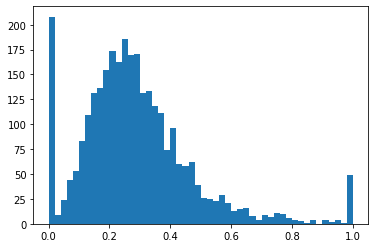

In [43]:
import matplotlib.pyplot as plt
plt.hist(scaled_table['walkability'], bins=50)
plt.show()

In [ ]:
# For reading in already calculated happiness data

# import pandas as pd
# happiness = pd.read_json('dist/data/vibetable.json', orient='index')['happiness']

# scaled_table['happiness'] = (happiness - np.quantile(happiness, 0.01)).clip(lower=0).replace(1, 0, inplace=False)

In [ ]:
df_listings.loc[df_listings['id'] == 1651]

In [39]:
%timeit calc_happiness(['I really enjoyed this.', 'This was a great use of my time.', 'Contrary to my expectations, I did enjoy this a lot.', 'I am unfortunately very busy this week', 'No worries mate.', 'Host was incredibly helpful'])

309 µs ± 2.42 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
